In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_task import CPC
from libs.ssl_data import SSLHBNDataModule
%load_ext autoreload
%autoreload 2

In [12]:
import wandb
run = wandb.init(project="eeg-ssl", job_type="training")

In [ ]:
import os
model = "1t2pzp1g" #"3k5y24ev"
artifact_dir = f'artifacts/model-{model}'
if model == "0cu5slnx":
    num_version = 11
elif model == "3k5y24ev":
    num_version = 31
else:
    num_version = 30
for version in range(num_version):
    if os.path.exists(f'{artifact_dir}:v{version}'):
        print(f"Artifact directory {artifact_dir}:v{version} already exists. Skipping download.")
        continue
    else:
        artifact = run.use_artifact(f'sccn/eeg-ssl/model-{model}:v{version}', type='model')
        artifact_dir = artifact.download()

Artifact directory artifacts/model-1t2pzp1g:v0 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v1 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v2 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v3 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v4 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v5 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v6 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v7 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v8 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v9 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v10 already exists. Skipping download.
Artifact directory artifacts/model-1t2pzp1g:v11 already exists. Skipping download.
Artifact direc

In [3]:
# load config from runs/config_CPC.yaml
import yaml
import lightning as L
with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)

ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['window_len_s'] = 20
config['data']['num_workers'] = 2

if model == "0cu5slnx":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRContextualizer'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None}
elif model == "3k5y24ev":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRLSTM'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512}
elif model == "1t2pzp1g":
    config['model']['init_args']['contextualizer_path'] = 'libs.bendr._BENDRContextualizer'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None} 
    config['model']['init_args']['encoder_path'] = 'libs.bendr._ConvEncoderBENDR'
    config['model']['init_args']['encoder_kwargs'] = {'encoder_h': 512, 'in_features': 128, 'dropout': 0.1} 

config['trainer']['callbacks'] = None
config['trainer']['logger'] = None

trainer = L.Trainer(**config['trainer'])
cpc_model = CPC.CPCLit(downsampling_factor=96, **config['model']['init_args'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
from collections import defaultdict
import json
mode = 'test'
for mode in ['val']: #, 'test']:
    if os.path.exists(f'experiment_results/model-{model}_scores-{mode}.json'):
        version_scores = json.load(open(f'experiment_results/model-{model}_scores-{mode}.json'))
    else:
        attributes = ['age', 'p_factor']
        version_scores = defaultdict(list)
        for attr in attributes:
            config['data']['target_label'] = attr

            artifact_dir = f'artifacts/model-{model}'
            if model == "0cu5slnx":
                num_version = 11
            elif model == "3k5y24ev":
                num_version = 31
            else:
                num_version = 20
            for version in range(num_version):
                artifact_path = f'{artifact_dir}:v{version}/model.ckpt'
                print(f'Loading model from {artifact_path}...')
                if mode == 'test':
                    print('Loading data module...')
                    litDataModule = SSLHBNDataModule(**config['data'])
                    litDataModule.setup(stage='test')
                    scores = trainer.test(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)
                elif mode == 'val':
                    print('Loading data module...')
                    litDataModule = SSLHBNDataModule(**config['data'])
                    litDataModule.setup(stage='validate')
                    scores = trainer.validate(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)
                version_scores[attr].append(scores)

        with open(f'experiment_results/model-{model}_scores-{mode}.json', 'w') as f:
            json.dump(version_scores, f)


Loading model from artifacts/model-1t2pzp1g:v0/model.ckpt...
Loading data module...


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v0/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v0/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2933509945869446               │
│               val_Regressor/R2                │              0.2960212826728821               │
│           val_Regressor/concordance           │              0.4568138122558594               │
│               val_Regressor/mae               │              2.3976662158966064               │
│               val_Regressor/mse               │               8.98865032196045                │
│         val_Regressor/subject_iqr_iqr         │              0.8685638904571533               │
│        val_Regressor/subject_iqr_mean         │              1.9846878051757812               │
│       val_Regressor/subject_iqr_median        │               1.982795000076294               │
│         val_Regressor/subject_iqr_std         │              0.6167185306549072               │
│         val_Regressor/subject_std_iqr         │              0.3621234893798828               │
│        val_Regressor/subject_std_mean         │              1.4924631118774414               │
│       val_Regressor/subject_std_median        │              1.4960711002349854               │
│         val_Regressor/subject_std_std         │              0.2648461163043976               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2459201067686081               │
│      val_Regressor/subject_with_mean_R2       │              0.4735181927680969               │
│  val_Regressor/subject_with_mean_concordance  │               0.530749499797821               │
│      val_Regressor/subject_with_mean_mae      │               2.028671979904175               │
│      val_Regressor/subject_with_mean_mse      │               6.513972759246826               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2476864904165268               │
│     val_Regressor/subject_with_median_R2      │              0.46592777967453003              │
│ val_Regressor/subject_with_median_concordance │              0.5274227857589722               │
│     val_Regressor/subject_with_median_mae     │              2.0622949600219727               │
│     val_Regressor/subject_with_median_mse     │               6.607885837554932               │
│                val_loss_epoch                 │               4.907222270965576               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v1/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v1/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v1/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2932257354259491               │
│               val_Regressor/R2                │              0.29662245512008667              │
│           val_Regressor/concordance           │              0.45753028988838196              │
│               val_Regressor/mae               │               2.39182186126709                │
│               val_Regressor/mse               │               8.980975151062012               │
│         val_Regressor/subject_iqr_iqr         │              0.8220990300178528               │
│        val_Regressor/subject_iqr_mean         │               1.949674367904663               │
│       val_Regressor/subject_iqr_median        │               1.899055004119873               │
│         val_Regressor/subject_iqr_std         │              0.6192039847373962               │
│         val_Regressor/subject_std_iqr         │              0.3606097996234894               │
│        val_Regressor/subject_std_mean         │              1.4921109676361084               │
│       val_Regressor/subject_std_median        │              1.4823065996170044               │
│         val_Regressor/subject_std_std         │              0.26982614398002625              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2460021823644638               │
│      val_Regressor/subject_with_mean_R2       │              0.47316670417785645              │
│  val_Regressor/subject_with_mean_concordance  │              0.5306749939918518               │
│      val_Regressor/subject_with_mean_mae      │               2.028597116470337               │
│      val_Regressor/subject_with_mean_mse      │              6.5183210372924805               │
│    val_Regressor/subject_with_median_NRMSE    │              0.24808518588542938              │
│     val_Regressor/subject_with_median_R2      │              0.46420717239379883              │
│ val_Regressor/subject_with_median_concordance │              0.5262852311134338               │
│     val_Regressor/subject_with_median_mae     │              2.0656282901763916               │
│     val_Regressor/subject_with_median_mse     │               6.629174709320068               │
│                val_loss_epoch                 │               3.906069040298462               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v2/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v2/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v2/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29313236474990845              │
│               val_Regressor/R2                │              0.2970702648162842               │
│           val_Regressor/concordance           │              0.4580638110637665               │
│               val_Regressor/mae               │              2.3872528076171875               │
│               val_Regressor/mse               │               8.97525691986084                │
│         val_Regressor/subject_iqr_iqr         │              0.7396271228790283               │
│        val_Regressor/subject_iqr_mean         │              1.9570972919464111               │
│       val_Regressor/subject_iqr_median        │              1.9367221593856812               │
│         val_Regressor/subject_iqr_std         │              0.5675882697105408               │
│         val_Regressor/subject_std_iqr         │               0.333267480134964               │
│        val_Regressor/subject_std_mean         │              1.4901649951934814               │
│       val_Regressor/subject_std_median        │              1.4948475360870361               │
│         val_Regressor/subject_std_std         │              0.2736957371234894               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24618472158908844              │
│      val_Regressor/subject_with_mean_R2       │               0.472384512424469               │
│  val_Regressor/subject_with_mean_concordance  │              0.5302034020423889               │
│      val_Regressor/subject_with_mean_mae      │              2.0278432369232178               │
│      val_Regressor/subject_with_mean_mse      │               6.527998924255371               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2490983009338379               │
│     val_Regressor/subject_with_median_R2      │              0.45982205867767334              │
│ val_Regressor/subject_with_median_concordance │              0.5224158763885498               │
│     val_Regressor/subject_with_median_mae     │               2.055802822113037               │
│     val_Regressor/subject_with_median_mse     │               6.683429718017578               │
│                val_loss_epoch                 │               3.292415142059326               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v3/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v3/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v3/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29313424229621887              │
│               val_Regressor/R2                │              0.29706138372421265              │
│           val_Regressor/concordance           │              0.4580516219139099               │
│               val_Regressor/mae               │               2.38554048538208                │
│               val_Regressor/mse               │               8.975370407104492               │
│         val_Regressor/subject_iqr_iqr         │               0.669388473033905               │
│        val_Regressor/subject_iqr_mean         │              1.9514445066452026               │
│       val_Regressor/subject_iqr_median        │              1.9179978370666504               │
│         val_Regressor/subject_iqr_std         │              0.5864530801773071               │
│         val_Regressor/subject_std_iqr         │              0.3349064588546753               │
│        val_Regressor/subject_std_mean         │              1.4878265857696533               │
│       val_Regressor/subject_std_median        │              1.4917826652526855               │
│         val_Regressor/subject_std_std         │              0.27723532915115356              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24646857380867004              │
│      val_Regressor/subject_with_mean_R2       │              0.4711671471595764               │
│  val_Regressor/subject_with_mean_concordance  │              0.5290900468826294               │
│      val_Regressor/subject_with_mean_mae      │               2.027945041656494               │
│      val_Regressor/subject_with_mean_mse      │               6.543061256408691               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25154295563697815              │
│     val_Regressor/subject_with_median_R2      │              0.4491673707962036               │
│ val_Regressor/subject_with_median_concordance │              0.5110124349594116               │
│     val_Regressor/subject_with_median_mae     │               2.071633815765381               │
│     val_Regressor/subject_with_median_mse     │               6.815256595611572               │
│                val_loss_epoch                 │               2.821936845779419               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v4/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v4/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v4/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2935750484466553               │
│               val_Regressor/R2                │              0.29494547843933105              │
│           val_Regressor/concordance           │              0.4555329382419586               │
│               val_Regressor/mae               │               2.390169143676758               │
│               val_Regressor/mse               │               9.002386093139648               │
│         val_Regressor/subject_iqr_iqr         │              0.6255954504013062               │
│        val_Regressor/subject_iqr_mean         │              1.9237935543060303               │
│       val_Regressor/subject_iqr_median        │              1.9131395816802979               │
│         val_Regressor/subject_iqr_std         │              0.5744234323501587               │
│         val_Regressor/subject_std_iqr         │              0.3426087200641632               │
│        val_Regressor/subject_std_mean         │              1.4818593263626099               │
│       val_Regressor/subject_std_median        │              1.4898500442504883               │
│         val_Regressor/subject_std_std         │              0.2737550437450409               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24746184051036835              │
│      val_Regressor/subject_with_mean_R2       │              0.4668962359428406               │
│  val_Regressor/subject_with_mean_concordance  │              0.5247096419334412               │
│      val_Regressor/subject_with_mean_mae      │               2.035100221633911               │
│      val_Regressor/subject_with_mean_mse      │              6.5959038734436035               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2513432204723358               │
│     val_Regressor/subject_with_median_R2      │              0.45004189014434814              │
│ val_Regressor/subject_with_median_concordance │              0.5111918449401855               │
│     val_Regressor/subject_with_median_mae     │               2.07037615776062                │
│     val_Regressor/subject_with_median_mse     │               6.804436206817627               │
│                val_loss_epoch                 │              2.4492976665496826               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v5/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v5/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v5/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29359251260757446              │
│               val_Regressor/R2                │              0.2948616147041321               │
│           val_Regressor/concordance           │              0.4554316997528076               │
│               val_Regressor/mae               │              2.3908157348632812               │
│               val_Regressor/mse               │               9.003457069396973               │
│         val_Regressor/subject_iqr_iqr         │              0.6048159599304199               │
│        val_Regressor/subject_iqr_mean         │              1.8956245183944702               │
│       val_Regressor/subject_iqr_median        │              1.8800687789916992               │
│         val_Regressor/subject_iqr_std         │              0.5677667856216431               │
│         val_Regressor/subject_std_iqr         │              0.34749770164489746              │
│        val_Regressor/subject_std_mean         │              1.4808188676834106               │
│       val_Regressor/subject_std_median        │              1.4882766008377075               │
│         val_Regressor/subject_std_std         │              0.2753258943557739               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2475874125957489               │
│      val_Regressor/subject_with_mean_R2       │              0.4663550853729248               │
│  val_Regressor/subject_with_mean_concordance  │              0.5240170955657959               │
│      val_Regressor/subject_with_mean_mae      │               2.034543752670288               │
│      val_Regressor/subject_with_mean_mse      │               6.602599143981934               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2516995668411255               │
│     val_Regressor/subject_with_median_R2      │              0.4484812617301941               │
│ val_Regressor/subject_with_median_concordance │               0.510568380355835               │
│     val_Regressor/subject_with_median_mae     │               2.084474563598633               │
│     val_Regressor/subject_with_median_mse     │               6.823745250701904               │
│                val_loss_epoch                 │               2.124828577041626               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v6/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v6/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v6/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2935940623283386               │
│               val_Regressor/R2                │              0.2948543429374695               │
│           val_Regressor/concordance           │              0.45542243123054504              │
│               val_Regressor/mae               │               2.391087532043457               │
│               val_Regressor/mse               │               9.00355052947998                │
│         val_Regressor/subject_iqr_iqr         │              0.6681341528892517               │
│        val_Regressor/subject_iqr_mean         │               1.882095217704773               │
│       val_Regressor/subject_iqr_median        │              1.8216769695281982               │
│         val_Regressor/subject_iqr_std         │              0.5537829995155334               │
│         val_Regressor/subject_std_iqr         │              0.3640751242637634               │
│        val_Regressor/subject_std_mean         │               1.480716347694397               │
│       val_Regressor/subject_std_median        │              1.4874343872070312               │
│         val_Regressor/subject_std_std         │              0.27712106704711914              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24760574102401733              │
│      val_Regressor/subject_with_mean_R2       │              0.46627604961395264              │
│  val_Regressor/subject_with_mean_concordance  │              0.5236966609954834               │
│      val_Regressor/subject_with_mean_mae      │              2.0333805084228516               │
│      val_Regressor/subject_with_mean_mse      │               6.603577136993408               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25160905718803406              │
│     val_Regressor/subject_with_median_R2      │              0.4488779306411743               │
│ val_Regressor/subject_with_median_concordance │              0.5110129117965698               │
│     val_Regressor/subject_with_median_mae     │              2.0857808589935303               │
│     val_Regressor/subject_with_median_mse     │               6.818837642669678               │
│                val_loss_epoch                 │              1.7987473011016846               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v7/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v7/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v7/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2936289310455322               │
│               val_Regressor/R2                │              0.29468679428100586              │
│           val_Regressor/concordance           │              0.45522454380989075              │
│               val_Regressor/mae               │               2.390702247619629               │
│               val_Regressor/mse               │               9.00568962097168                │
│         val_Regressor/subject_iqr_iqr         │               0.688661515712738               │
│        val_Regressor/subject_iqr_mean         │              1.8742852210998535               │
│       val_Regressor/subject_iqr_median        │              1.8329501152038574               │
│         val_Regressor/subject_iqr_std         │              0.5422775149345398               │
│         val_Regressor/subject_std_iqr         │              0.3443305790424347               │
│        val_Regressor/subject_std_mean         │               1.480419397354126               │
│       val_Regressor/subject_std_median        │              1.4901342391967773               │
│         val_Regressor/subject_std_std         │               0.279556542634964               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24763284623622894              │
│      val_Regressor/subject_with_mean_R2       │              0.4661591053009033               │
│  val_Regressor/subject_with_mean_concordance  │              0.5233166813850403               │
│      val_Regressor/subject_with_mean_mae      │               2.03283953666687                │
│      val_Regressor/subject_with_mean_mse      │               6.605023384094238               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2508559226989746               │
│     val_Regressor/subject_with_median_R2      │              0.45217227935791016              │
│ val_Regressor/subject_with_median_concordance │              0.5137174725532532               │
│     val_Regressor/subject_with_median_mae     │               2.082988977432251               │
│     val_Regressor/subject_with_median_mse     │               6.778077602386475               │
│                val_loss_epoch                 │               1.510003924369812               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v8/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v8/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v8/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2935945689678192               │
│               val_Regressor/R2                │              0.2948518395423889               │
│           val_Regressor/concordance           │              0.45542094111442566              │
│               val_Regressor/mae               │               2.389902114868164               │
│               val_Regressor/mse               │               9.003582000732422               │
│         val_Regressor/subject_iqr_iqr         │              0.7308213710784912               │
│        val_Regressor/subject_iqr_mean         │              1.8654098510742188               │
│       val_Regressor/subject_iqr_median        │              1.8174142837524414               │
│         val_Regressor/subject_iqr_std         │              0.5310467481613159               │
│         val_Regressor/subject_std_iqr         │              0.33412453532218933              │
│        val_Regressor/subject_std_mean         │               1.481062889099121               │
│       val_Regressor/subject_std_median        │              1.4799261093139648               │
│         val_Regressor/subject_std_std         │              0.2817310094833374               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24753767251968384              │
│      val_Regressor/subject_with_mean_R2       │              0.4665694236755371               │
│  val_Regressor/subject_with_mean_concordance  │              0.5234971046447754               │
│      val_Regressor/subject_with_mean_mae      │              2.0313127040863037               │
│      val_Regressor/subject_with_mean_mse      │               6.599946975708008               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2510107159614563               │
│     val_Regressor/subject_with_median_R2      │              0.4514959454536438               │
│ val_Regressor/subject_with_median_concordance │              0.5115421414375305               │
│     val_Regressor/subject_with_median_mae     │              2.0793356895446777               │
│     val_Regressor/subject_with_median_mse     │               6.786445617675781               │
│                val_loss_epoch                 │               1.27717125415802                │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v9/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v9/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v9/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2936019003391266               │
│               val_Regressor/R2                │              0.2948164939880371               │
│           val_Regressor/concordance           │              0.4553799033164978               │
│               val_Regressor/mae               │              2.3898887634277344               │
│               val_Regressor/mse               │               9.004033088684082               │
│         val_Regressor/subject_iqr_iqr         │              0.7377303838729858               │
│        val_Regressor/subject_iqr_mean         │              1.8661226034164429               │
│       val_Regressor/subject_iqr_median        │              1.8523058891296387               │
│         val_Regressor/subject_iqr_std         │              0.5286688804626465               │
│         val_Regressor/subject_std_iqr         │              0.3502870202064514               │
│        val_Regressor/subject_std_mean         │              1.4813148975372314               │
│       val_Regressor/subject_std_median        │              1.4656150341033936               │
│         val_Regressor/subject_std_std         │              0.2829850912094116               │
│     val_Regressor/subject_with_mean_NRMSE     │               0.247517392039299               │
│      val_Regressor/subject_with_mean_R2       │              0.4666568636894226               │
│  val_Regressor/subject_with_mean_concordance  │              0.5233784914016724               │
│      val_Regressor/subject_with_mean_mae      │               2.030301809310913               │
│      val_Regressor/subject_with_mean_mse      │               6.598865032196045               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25077685713768005              │
│     val_Regressor/subject_with_median_R2      │              0.4525175094604492               │
│ val_Regressor/subject_with_median_concordance │              0.5124731063842773               │
│     val_Regressor/subject_with_median_mae     │               2.069733142852783               │
│     val_Regressor/subject_with_median_mse     │               6.773806571960449               │
│                val_loss_epoch                 │              1.0474731922149658               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v10/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v10/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v10/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2936214506626129               │
│               val_Regressor/R2                │              0.29472261667251587              │
│           val_Regressor/concordance           │              0.45526736974716187              │
│               val_Regressor/mae               │               2.390599012374878               │
│               val_Regressor/mse               │               9.005232810974121               │
│         val_Regressor/subject_iqr_iqr         │              0.7040420770645142               │
│        val_Regressor/subject_iqr_mean         │              1.8628648519515991               │
│       val_Regressor/subject_iqr_median        │               1.878614902496338               │
│         val_Regressor/subject_iqr_std         │              0.5218580961227417               │
│         val_Regressor/subject_std_iqr         │              0.33708101511001587              │
│        val_Regressor/subject_std_mean         │              1.4812393188476562               │
│       val_Regressor/subject_std_median        │              1.4637110233306885               │
│         val_Regressor/subject_std_std         │              0.28367194533348083              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24753189086914062              │
│      val_Regressor/subject_with_mean_R2       │              0.4665943384170532               │
│  val_Regressor/subject_with_mean_concordance  │              0.5231627821922302               │
│      val_Regressor/subject_with_mean_mae      │              2.0293447971343994               │
│      val_Regressor/subject_with_mean_mse      │               6.599638938903809               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2510445713996887               │
│     val_Regressor/subject_with_median_R2      │              0.45134806632995605              │
│ val_Regressor/subject_with_median_concordance │              0.5112383961677551               │
│     val_Regressor/subject_with_median_mae     │              2.0627388954162598               │
│     val_Regressor/subject_with_median_mse     │               6.788275718688965               │
│                val_loss_epoch                 │              0.8810777068138123               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v11/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v11/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v11/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29362380504608154              │
│               val_Regressor/R2                │              0.29471129179000854              │
│           val_Regressor/concordance           │              0.45525267720222473              │
│               val_Regressor/mae               │              2.3917412757873535               │
│               val_Regressor/mse               │               9.005376815795898               │
│         val_Regressor/subject_iqr_iqr         │               0.757623016834259               │
│        val_Regressor/subject_iqr_mean         │              1.8680840730667114               │
│       val_Regressor/subject_iqr_median        │              1.8375983238220215               │
│         val_Regressor/subject_iqr_std         │              0.5177677869796753               │
│         val_Regressor/subject_std_iqr         │              0.3423007130622864               │
│        val_Regressor/subject_std_mean         │              1.4809088706970215               │
│       val_Regressor/subject_std_median        │              1.4639503955841064               │
│         val_Regressor/subject_std_std         │              0.28313642740249634              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24757003784179688              │
│      val_Regressor/subject_with_mean_R2       │              0.4664299488067627               │
│  val_Regressor/subject_with_mean_concordance  │              0.5229508876800537               │
│      val_Regressor/subject_with_mean_mae      │               2.028712272644043               │
│      val_Regressor/subject_with_mean_mse      │               6.601673126220703               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25037890672683716              │
│     val_Regressor/subject_with_median_R2      │              0.4542537331581116               │
│ val_Regressor/subject_with_median_concordance │              0.5142356157302856               │
│     val_Regressor/subject_with_median_mae     │               2.060798168182373               │
│     val_Regressor/subject_with_median_mse     │               6.75232458114624                │
│                val_loss_epoch                 │              0.7181593775749207               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v12/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v12/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v12/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2936875820159912               │
│               val_Regressor/R2                │              0.29440492391586304              │
│           val_Regressor/concordance           │              0.45488837361335754              │
│               val_Regressor/mae               │              2.3938612937927246               │
│               val_Regressor/mse               │               9.009288787841797               │
│         val_Regressor/subject_iqr_iqr         │              0.7142755389213562               │
│        val_Regressor/subject_iqr_mean         │              1.8827522993087769               │
│       val_Regressor/subject_iqr_median        │              1.8929083347320557               │
│         val_Regressor/subject_iqr_std         │              0.5232621431350708               │
│         val_Regressor/subject_std_iqr         │              0.3336450159549713               │
│        val_Regressor/subject_std_mean         │               1.479805588722229               │
│       val_Regressor/subject_std_median        │               1.453278660774231               │
│         val_Regressor/subject_std_std         │              0.2813219428062439               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24774064123630524              │
│      val_Regressor/subject_with_mean_R2       │              0.4656943678855896               │
│  val_Regressor/subject_with_mean_concordance  │              0.5222283005714417               │
│      val_Regressor/subject_with_mean_mae      │               2.029266834259033               │
│      val_Regressor/subject_with_mean_mse      │               6.610774040222168               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2511501908302307               │
│     val_Regressor/subject_with_median_R2      │              0.45088618993759155              │
│ val_Regressor/subject_with_median_concordance │              0.5112350583076477               │
│     val_Regressor/subject_with_median_mae     │              2.0720765590667725               │
│     val_Regressor/subject_with_median_mse     │               6.793990135192871               │
│                val_loss_epoch                 │              0.5865081548690796               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v13/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v13/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v13/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2937129735946655               │
│               val_Regressor/R2                │              0.2942829132080078               │
│           val_Regressor/concordance           │              0.45474278926849365              │
│               val_Regressor/mae               │              2.3955538272857666               │
│               val_Regressor/mse               │               9.010847091674805               │
│         val_Regressor/subject_iqr_iqr         │              0.6405291557312012               │
│        val_Regressor/subject_iqr_mean         │              1.8925747871398926               │
│       val_Regressor/subject_iqr_median        │              1.9184101819992065               │
│         val_Regressor/subject_iqr_std         │              0.5102139711380005               │
│         val_Regressor/subject_std_iqr         │              0.3293909728527069               │
│        val_Regressor/subject_std_mean         │               1.478948712348938               │
│       val_Regressor/subject_std_median        │              1.4422205686569214               │
│         val_Regressor/subject_std_std         │              0.27837398648262024              │
│     val_Regressor/subject_with_mean_NRMSE     │               0.247880756855011               │
│      val_Regressor/subject_with_mean_R2       │              0.4650897979736328               │
│  val_Regressor/subject_with_mean_concordance  │              0.5217049717903137               │
│      val_Regressor/subject_with_mean_mae      │              2.0300309658050537               │
│      val_Regressor/subject_with_mean_mse      │                6.6182541847229                │
│    val_Regressor/subject_with_median_NRMSE    │              0.2515013515949249               │
│     val_Regressor/subject_with_median_R2      │               0.449349582195282               │
│ val_Regressor/subject_with_median_concordance │              0.5095887184143066               │
│     val_Regressor/subject_with_median_mae     │               2.076505661010742               │
│     val_Regressor/subject_with_median_mse     │               6.81300163269043                │
│                val_loss_epoch                 │              0.4773191213607788               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v14/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v14/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v14/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2937728464603424               │
│               val_Regressor/R2                │              0.29399508237838745              │
│           val_Regressor/concordance           │              0.45439791679382324              │
│               val_Regressor/mae               │               2.397616386413574               │
│               val_Regressor/mse               │               9.014521598815918               │
│         val_Regressor/subject_iqr_iqr         │              0.6105238199234009               │
│        val_Regressor/subject_iqr_mean         │              1.8997697830200195               │
│       val_Regressor/subject_iqr_median        │              1.9060006141662598               │
│         val_Regressor/subject_iqr_std         │              0.4888562262058258               │
│         val_Regressor/subject_std_iqr         │              0.3644689917564392               │
│        val_Regressor/subject_std_mean         │              1.4776685237884521               │
│       val_Regressor/subject_std_median        │              1.4436068534851074               │
│         val_Regressor/subject_std_std         │              0.27531445026397705              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2480885535478592               │
│      val_Regressor/subject_with_mean_R2       │              0.4641925096511841               │
│  val_Regressor/subject_with_mean_concordance  │              0.5208967328071594               │
│      val_Regressor/subject_with_mean_mae      │              2.0312936305999756               │
│      val_Regressor/subject_with_mean_mse      │              6.6293559074401855               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2515721321105957               │
│     val_Regressor/subject_with_median_R2      │              0.44903963804244995              │
│ val_Regressor/subject_with_median_concordance │              0.5093116164207458               │
│     val_Regressor/subject_with_median_mae     │              2.0805602073669434               │
│     val_Regressor/subject_with_median_mse     │               6.816837310791016               │
│                val_loss_epoch                 │              0.37647151947021484              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v15/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v15/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v15/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2937942147254944               │
│               val_Regressor/R2                │              0.29389238357543945              │
│           val_Regressor/concordance           │              0.45427632331848145              │
│               val_Regressor/mae               │               2.399494171142578               │
│               val_Regressor/mse               │               9.015832901000977               │
│         val_Regressor/subject_iqr_iqr         │              0.6165305376052856               │
│        val_Regressor/subject_iqr_mean         │               1.916365146636963               │
│       val_Regressor/subject_iqr_median        │               1.917444109916687               │
│         val_Regressor/subject_iqr_std         │              0.4680171608924866               │
│         val_Regressor/subject_std_iqr         │              0.3361518681049347               │
│        val_Regressor/subject_std_mean         │              1.4763280153274536               │
│       val_Regressor/subject_std_median        │              1.4314707517623901               │
│         val_Regressor/subject_std_std         │              0.2723003625869751               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2482716590166092               │
│      val_Regressor/subject_with_mean_R2       │              0.46340131759643555              │
│  val_Regressor/subject_with_mean_concordance  │              0.5202860832214355               │
│      val_Regressor/subject_with_mean_mae      │               2.033018112182617               │
│      val_Regressor/subject_with_mean_mse      │              6.6391448974609375               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2517037093639374               │
│     val_Regressor/subject_with_median_R2      │              0.44846320152282715              │
│ val_Regressor/subject_with_median_concordance │              0.5079449415206909               │
│     val_Regressor/subject_with_median_mae     │              2.0810599327087402               │
│     val_Regressor/subject_with_median_mse     │               6.82396936416626                │
│                val_loss_epoch                 │              0.3060930073261261               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v16/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v16/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v16/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29383087158203125              │
│               val_Regressor/R2                │              0.29371631145477295              │
│           val_Regressor/concordance           │              0.45406579971313477              │
│               val_Regressor/mae               │               2.401604652404785               │
│               val_Regressor/mse               │               9.018081665039062               │
│         val_Regressor/subject_iqr_iqr         │              0.5855953693389893               │
│        val_Regressor/subject_iqr_mean         │              1.9263617992401123               │
│       val_Regressor/subject_iqr_median        │               1.920628309249878               │
│         val_Regressor/subject_iqr_std         │              0.46169936656951904              │
│         val_Regressor/subject_std_iqr         │              0.34568342566490173              │
│        val_Regressor/subject_std_mean         │              1.4751557111740112               │
│       val_Regressor/subject_std_median        │               1.440148115158081               │
│         val_Regressor/subject_std_std         │              0.26912105083465576              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2484670877456665               │
│      val_Regressor/subject_with_mean_R2       │              0.46255630254745483              │
│  val_Regressor/subject_with_mean_concordance  │              0.5195823311805725               │
│      val_Regressor/subject_with_mean_mae      │              2.0345356464385986               │
│      val_Regressor/subject_with_mean_mse      │               6.649600028991699               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25251245498657227              │
│     val_Regressor/subject_with_median_R2      │              0.44491320848464966              │
│ val_Regressor/subject_with_median_concordance │              0.5039353370666504               │
│     val_Regressor/subject_with_median_mae     │               2.088310718536377               │
│     val_Regressor/subject_with_median_mse     │               6.867891788482666               │
│                val_loss_epoch                 │              0.2507428824901581               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v17/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v17/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v17/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.2938123643398285               │
│               val_Regressor/R2                │              0.2938053607940674               │
│           val_Regressor/concordance           │              0.4541719853878021               │
│               val_Regressor/mae               │              2.4032504558563232               │
│               val_Regressor/mse               │               9.016944885253906               │
│         val_Regressor/subject_iqr_iqr         │              0.5441677570343018               │
│        val_Regressor/subject_iqr_mean         │              1.9338730573654175               │
│       val_Regressor/subject_iqr_median        │               1.934793472290039               │
│         val_Regressor/subject_iqr_std         │              0.46248698234558105              │
│         val_Regressor/subject_std_iqr         │              0.35907524824142456              │
│        val_Regressor/subject_std_mean         │              1.4747756719589233               │
│       val_Regressor/subject_std_median        │              1.4469910860061646               │
│         val_Regressor/subject_std_std         │              0.2659316658973694               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24856145679950714              │
│      val_Regressor/subject_with_mean_R2       │              0.46214789152145386              │
│  val_Regressor/subject_with_mean_concordance  │              0.5193243622779846               │
│      val_Regressor/subject_with_mean_mae      │              2.0356030464172363               │
│      val_Regressor/subject_with_mean_mse      │               6.654653072357178               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2531522214412689               │
│     val_Regressor/subject_with_median_R2      │              0.4420969486236572               │
│ val_Regressor/subject_with_median_concordance │               0.500715434551239               │
│     val_Regressor/subject_with_median_mae     │               2.093388080596924               │
│     val_Regressor/subject_with_median_mse     │               6.902736186981201               │
│                val_loss_epoch                 │              0.2194257527589798               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v18/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v18/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v18/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29372841119766235              │
│               val_Regressor/R2                │              0.2942087650299072               │
│           val_Regressor/concordance           │              0.4546540379524231               │
│               val_Regressor/mae               │              2.4047884941101074               │
│               val_Regressor/mse               │               9.01179313659668                │
│         val_Regressor/subject_iqr_iqr         │              0.5138809084892273               │
│        val_Regressor/subject_iqr_mean         │               1.929116129875183               │
│       val_Regressor/subject_iqr_median        │              1.9198676347732544               │
│         val_Regressor/subject_iqr_std         │              0.46301335096359253              │
│         val_Regressor/subject_std_iqr         │              0.3700234293937683               │
│        val_Regressor/subject_std_mean         │              1.4750549793243408               │
│       val_Regressor/subject_std_median        │              1.4467710256576538               │
│         val_Regressor/subject_std_std         │              0.2633800804615021               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.24854616820812225              │
│      val_Regressor/subject_with_mean_R2       │              0.46221405267715454              │
│  val_Regressor/subject_with_mean_concordance  │              0.5195555090904236               │
│      val_Regressor/subject_with_mean_mae      │               2.035048007965088               │
│      val_Regressor/subject_with_mean_mse      │               6.653834342956543               │
│    val_Regressor/subject_with_median_NRMSE    │              0.2529957592487335               │
│     val_Regressor/subject_with_median_R2      │              0.44278615713119507              │
│ val_Regressor/subject_with_median_concordance │              0.5011007189750671               │
│     val_Regressor/subject_with_median_mae     │              2.0934982299804688               │
│     val_Regressor/subject_with_median_mse     │              6.8942084312438965               │
│                val_loss_epoch                 │              0.1818469613790512               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v19/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v19/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v19/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.29367250204086304              │
│               val_Regressor/R2                │              0.2944774627685547               │
│           val_Regressor/concordance           │              0.4549728333950043               │
│               val_Regressor/mae               │               2.406027317047119               │
│               val_Regressor/mse               │               9.008362770080566               │
│         val_Regressor/subject_iqr_iqr         │               0.527613639831543               │
│        val_Regressor/subject_iqr_mean         │              1.9251620769500732               │
│       val_Regressor/subject_iqr_median        │              1.9078733921051025               │
│         val_Regressor/subject_iqr_std         │              0.4636859893798828               │
│         val_Regressor/subject_std_iqr         │              0.3587873876094818               │
│        val_Regressor/subject_std_mean         │              1.4749926328659058               │
│       val_Regressor/subject_std_median        │              1.4435616731643677               │
│         val_Regressor/subject_std_std         │              0.2606666386127472               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.2485809326171875               │
│      val_Regressor/subject_with_mean_R2       │              0.46206361055374146              │
│  val_Regressor/subject_with_mean_concordance  │              0.5195515155792236               │
│      val_Regressor/subject_with_mean_mae      │               2.035384178161621               │
│      val_Regressor/subject_with_mean_mse      │               6.655695915222168               │
│    val_Regressor/subject_with_median_NRMSE    │              0.25276800990104675              │
│     val_Regressor/subject_with_median_R2      │              0.44378918409347534              │
│ val_Regressor/subject_with_median_concordance │              0.5017176270484924               │
│     val_Regressor/subject_with_median_mae     │              2.0903453826904297               │
│     val_Regressor/subject_with_median_mse     │               6.881799221038818               │
│                val_loss_epoch                 │              0.14482317864894867              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v0/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v0/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v0/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 41. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.80646896362305               │
│               val_Regressor/R2                │              0.2601180672645569               │
│           val_Regressor/concordance           │              0.4128473699092865               │
│               val_Regressor/mae               │              0.6039822101593018               │
│               val_Regressor/mse               │              0.5616744756698608               │
│         val_Regressor/subject_iqr_iqr         │              0.15284736454486847              │
│        val_Regressor/subject_iqr_mean         │              0.46670255064964294              │
│       val_Regressor/subject_iqr_median        │              0.45648738741874695              │
│         val_Regressor/subject_iqr_std         │              0.12679961323738098              │
│         val_Regressor/subject_std_iqr         │              0.08628985285758972              │
│        val_Regressor/subject_std_mean         │              0.35744765400886536              │
│       val_Regressor/subject_std_median        │               0.354796826839447               │
│         val_Regressor/subject_std_std         │              0.06380334496498108              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.18540573120117               │
│      val_Regressor/subject_with_mean_R2       │              0.4330933690071106               │
│  val_Regressor/subject_with_mean_concordance  │              0.47614744305610657              │
│      val_Regressor/subject_with_mean_mae      │              0.5323375463485718               │
│      val_Regressor/subject_with_mean_mse      │              0.44462478160858154              │
│    val_Regressor/subject_with_median_NRMSE    │               -37.2005615234375               │
│     val_Regressor/subject_with_median_R2      │              0.43263113498687744              │
│ val_Regressor/subject_with_median_concordance │              0.47748297452926636              │
│     val_Regressor/subject_with_median_mae     │              0.5322379469871521               │
│     val_Regressor/subject_with_median_mse     │              0.44498732686042786              │
│                val_loss_epoch                 │               4.893316745758057               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v1/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v1/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v1/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.666168212890625               │
│               val_Regressor/R2                │              0.2640444040298462               │
│           val_Regressor/concordance           │              0.4177769124507904               │
│               val_Regressor/mae               │               0.602205216884613               │
│               val_Regressor/mse               │              0.5586938261985779               │
│         val_Regressor/subject_iqr_iqr         │               0.163813054561615               │
│        val_Regressor/subject_iqr_mean         │               0.471290647983551               │
│       val_Regressor/subject_iqr_median        │              0.4595247507095337               │
│         val_Regressor/subject_iqr_std         │              0.12557029724121094              │
│         val_Regressor/subject_std_iqr         │              0.0906170979142189               │
│        val_Regressor/subject_std_mean         │              0.3599705696105957               │
│       val_Regressor/subject_std_median        │              0.3606604337692261               │
│         val_Regressor/subject_std_std         │              0.06462135910987854              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.988739013671875              │
│      val_Regressor/subject_with_mean_R2       │              0.43907397985458374              │
│  val_Regressor/subject_with_mean_concordance  │              0.48258092999458313              │
│      val_Regressor/subject_with_mean_mae      │              0.5296374559402466               │
│      val_Regressor/subject_with_mean_mse      │              0.4399341940879822               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.19236373901367               │
│     val_Regressor/subject_with_median_R2      │              0.4328809976577759               │
│ val_Regressor/subject_with_median_concordance │               0.478224515914917               │
│     val_Regressor/subject_with_median_mae     │              0.5349019169807434               │
│     val_Regressor/subject_with_median_mse     │               0.444791316986084               │
│                val_loss_epoch                 │               3.892364025115967               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v2/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v2/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v2/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.54877853393555               │
│               val_Regressor/R2                │              0.26732152700424194              │
│           val_Regressor/concordance           │               0.421867698431015               │
│               val_Regressor/mae               │              0.6010467410087585               │
│               val_Regressor/mse               │              0.5562060475349426               │
│         val_Regressor/subject_iqr_iqr         │              0.18788667023181915              │
│        val_Regressor/subject_iqr_mean         │              0.4684864282608032               │
│       val_Regressor/subject_iqr_median        │              0.44847428798675537              │
│         val_Regressor/subject_iqr_std         │              0.13348287343978882              │
│         val_Regressor/subject_std_iqr         │              0.08633511513471603              │
│        val_Regressor/subject_std_mean         │              0.36192071437835693              │
│       val_Regressor/subject_std_median        │              0.3616390824317932               │
│         val_Regressor/subject_std_std         │              0.06541868299245834              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.821311950683594              │
│      val_Regressor/subject_with_mean_R2       │              0.4441404938697815               │
│  val_Regressor/subject_with_mean_concordance  │              0.48797738552093506              │
│      val_Regressor/subject_with_mean_mae      │              0.5278798341751099               │
│      val_Regressor/subject_with_mean_mse      │              0.4359605014324188               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.016014099121094              │
│     val_Regressor/subject_with_median_R2      │              0.43824630975723267              │
│ val_Regressor/subject_with_median_concordance │              0.48375576734542847              │
│     val_Regressor/subject_with_median_mae     │              0.5309850573539734               │
│     val_Regressor/subject_with_median_mse     │              0.44058331847190857              │
│                val_loss_epoch                 │               3.277416706085205               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v3/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v3/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v3/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.47611999511719               │
│               val_Regressor/R2                │              0.26934629678726196              │
│           val_Regressor/concordance           │              0.4243856966495514               │
│               val_Regressor/mae               │              0.6001034379005432               │
│               val_Regressor/mse               │              0.5546689629554749               │
│         val_Regressor/subject_iqr_iqr         │              0.18109719455242157              │
│        val_Regressor/subject_iqr_mean         │              0.46343567967414856              │
│       val_Regressor/subject_iqr_median        │              0.4498251974582672               │
│         val_Regressor/subject_iqr_std         │              0.1373417228460312               │
│         val_Regressor/subject_std_iqr         │              0.08214566856622696              │
│        val_Regressor/subject_std_mean         │              0.36313098669052124              │
│       val_Regressor/subject_std_median        │              0.36546963453292847              │
│         val_Regressor/subject_std_std         │              0.0652388483285904               │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.713050842285156              │
│      val_Regressor/subject_with_mean_R2       │              0.4474042057991028               │
│  val_Regressor/subject_with_mean_concordance  │              0.4914950132369995               │
│      val_Regressor/subject_with_mean_mae      │              0.5270990133285522               │
│      val_Regressor/subject_with_mean_mse      │              0.4334007799625397               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.02631378173828               │
│     val_Regressor/subject_with_median_R2      │              0.4379338026046753               │
│ val_Regressor/subject_with_median_concordance │              0.48361945152282715              │
│     val_Regressor/subject_with_median_mae     │              0.5292734503746033               │
│     val_Regressor/subject_with_median_mse     │              0.44082844257354736              │
│                val_loss_epoch                 │               2.82908034324646                │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v4/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v4/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v4/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.576194763183594               │
│               val_Regressor/R2                │              0.2665567994117737               │
│           val_Regressor/concordance           │              0.4209159314632416               │
│               val_Regressor/mae               │              0.6008015275001526               │
│               val_Regressor/mse               │              0.5567865371704102               │
│         val_Regressor/subject_iqr_iqr         │              0.18178287148475647              │
│        val_Regressor/subject_iqr_mean         │              0.46101194620132446              │
│       val_Regressor/subject_iqr_median        │              0.46300792694091797              │
│         val_Regressor/subject_iqr_std         │              0.13896185159683228              │
│         val_Regressor/subject_std_iqr         │              0.0868612676858902               │
│        val_Regressor/subject_std_mean         │              0.36232390999794006              │
│       val_Regressor/subject_std_median        │              0.36641085147857666              │
│         val_Regressor/subject_std_std         │             0.062385838478803635              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.83102798461914               │
│      val_Regressor/subject_with_mean_R2       │               0.443847119808197               │
│  val_Regressor/subject_with_mean_concordance  │              0.48744094371795654              │
│      val_Regressor/subject_with_mean_mae      │              0.5289289951324463               │
│      val_Regressor/subject_with_mean_mse      │              0.4361906349658966               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.07693862915039               │
│     val_Regressor/subject_with_median_R2      │              0.43639570474624634              │
│ val_Regressor/subject_with_median_concordance │              0.4817471206188202               │
│     val_Regressor/subject_with_median_mae     │              0.5314019322395325               │
│     val_Regressor/subject_with_median_mse     │              0.4420347809791565               │
│                val_loss_epoch                 │               2.429124355316162               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v5/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v5/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v5/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.582881927490234               │
│               val_Regressor/R2                │              0.2663702368736267               │
│           val_Regressor/concordance           │              0.42068296670913696              │
│               val_Regressor/mae               │              0.6010945439338684               │
│               val_Regressor/mse               │              0.5569281578063965               │
│         val_Regressor/subject_iqr_iqr         │              0.19306565821170807              │
│        val_Regressor/subject_iqr_mean         │              0.4590628743171692               │
│       val_Regressor/subject_iqr_median        │              0.4493480920791626               │
│         val_Regressor/subject_iqr_std         │              0.13321805000305176              │
│         val_Regressor/subject_std_iqr         │              0.0925363078713417               │
│        val_Regressor/subject_std_mean         │              0.3624870479106903               │
│       val_Regressor/subject_std_median        │              0.3623606562614441               │
│         val_Regressor/subject_std_std         │             0.061631035059690475              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.832130432128906              │
│      val_Regressor/subject_with_mean_R2       │              0.4438138008117676               │
│  val_Regressor/subject_with_mean_concordance  │              0.4873834550380707               │
│      val_Regressor/subject_with_mean_mae      │              0.5292311906814575               │
│      val_Regressor/subject_with_mean_mse      │              0.4362167418003082               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.14615249633789               │
│     val_Regressor/subject_with_median_R2      │              0.43428951501846313              │
│ val_Regressor/subject_with_median_concordance │              0.4795930087566376               │
│     val_Regressor/subject_with_median_mae     │              0.5318294763565063               │
│     val_Regressor/subject_with_median_mse     │              0.4436866343021393               │
│                val_loss_epoch                 │              2.1256422996520996               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v6/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v6/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v6/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.605247497558594               │
│               val_Regressor/R2                │              0.26574617624282837              │
│           val_Regressor/concordance           │              0.4199061691761017               │
│               val_Regressor/mae               │              0.6016137003898621               │
│               val_Regressor/mse               │              0.5574019551277161               │
│         val_Regressor/subject_iqr_iqr         │              0.16970810294151306              │
│        val_Regressor/subject_iqr_mean         │               0.462667316198349               │
│       val_Regressor/subject_iqr_median        │              0.46466878056526184              │
│         val_Regressor/subject_iqr_std         │              0.12688590586185455              │
│         val_Regressor/subject_std_iqr         │              0.09546912461519241              │
│        val_Regressor/subject_std_mean         │              0.3622351586818695               │
│       val_Regressor/subject_std_median        │              0.3626481592655182               │
│         val_Regressor/subject_std_std         │             0.061591003090143204              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.85838317871094               │
│      val_Regressor/subject_with_mean_R2       │              0.44302064180374146              │
│  val_Regressor/subject_with_mean_concordance  │              0.48652008175849915              │
│      val_Regressor/subject_with_mean_mae      │               0.529533863067627               │
│      val_Regressor/subject_with_mean_mse      │              0.4368388056755066               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.241329193115234              │
│     val_Regressor/subject_with_median_R2      │              0.43138688802719116              │
│ val_Regressor/subject_with_median_concordance │              0.47731274366378784              │
│     val_Regressor/subject_with_median_mae     │              0.5353086590766907               │
│     val_Regressor/subject_with_median_mse     │              0.44596320390701294              │
│                val_loss_epoch                 │               1.808624505996704               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v7/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v7/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v7/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.6460075378418                │
│               val_Regressor/R2                │              0.2646077871322632               │
│           val_Regressor/concordance           │              0.41848182678222656              │
│               val_Regressor/mae               │              0.6021265983581543               │
│               val_Regressor/mse               │              0.5582661628723145               │
│         val_Regressor/subject_iqr_iqr         │              0.1742868721485138               │
│        val_Regressor/subject_iqr_mean         │              0.4637669324874878               │
│       val_Regressor/subject_iqr_median        │              0.46144935488700867              │
│         val_Regressor/subject_iqr_std         │              0.1286122053861618               │
│         val_Regressor/subject_std_iqr         │              0.09177494794130325              │
│        val_Regressor/subject_std_mean         │              0.3616155982017517               │
│       val_Regressor/subject_std_median        │              0.3629593253135681               │
│         val_Regressor/subject_std_std         │              0.06206832081079483              │
│     val_Regressor/subject_with_mean_NRMSE     │                 -36.912109375                 │
│      val_Regressor/subject_with_mean_R2       │              0.44139569997787476              │
│  val_Regressor/subject_with_mean_concordance  │              0.48475104570388794              │
│      val_Regressor/subject_with_mean_mae      │              0.5303612947463989               │
│      val_Regressor/subject_with_mean_mse      │               0.438113272190094               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.32069396972656               │
│     val_Regressor/subject_with_median_R2      │              0.42896080017089844              │
│ val_Regressor/subject_with_median_concordance │              0.4740760624408722               │
│     val_Regressor/subject_with_median_mae     │              0.5354104042053223               │
│     val_Regressor/subject_with_median_mse     │              0.44786596298217773              │
│                val_loss_epoch                 │              1.5347468852996826               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v8/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v8/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v8/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.700130462646484               │
│               val_Regressor/R2                │              0.2630949020385742               │
│           val_Regressor/concordance           │              0.4165876507759094               │
│               val_Regressor/mae               │              0.6030032634735107               │
│               val_Regressor/mse               │              0.5594146251678467               │
│         val_Regressor/subject_iqr_iqr         │              0.1836967170238495               │
│        val_Regressor/subject_iqr_mean         │              0.4652145206928253               │
│       val_Regressor/subject_iqr_median        │              0.45847561955451965              │
│         val_Regressor/subject_iqr_std         │              0.13119013607501984              │
│         val_Regressor/subject_std_iqr         │              0.09564389288425446              │
│        val_Regressor/subject_std_mean         │              0.3608092665672302               │
│       val_Regressor/subject_std_median        │              0.3629390299320221               │
│         val_Regressor/subject_std_std         │              0.06274194270372391              │
│     val_Regressor/subject_with_mean_NRMSE     │              -36.98613357543945               │
│      val_Regressor/subject_with_mean_R2       │              0.4391530156135559               │
│  val_Regressor/subject_with_mean_concordance  │              0.48232653737068176              │
│      val_Regressor/subject_with_mean_mae      │              0.5315588712692261               │
│      val_Regressor/subject_with_mean_mse      │              0.43987220525741577              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.311527252197266              │
│     val_Regressor/subject_with_median_R2      │              0.4292411208152771               │
│ val_Regressor/subject_with_median_concordance │              0.47470998764038086              │
│     val_Regressor/subject_with_median_mae     │              0.5357825756072998               │
│     val_Regressor/subject_with_median_mse     │              0.4476460814476013               │
│                val_loss_epoch                 │              1.2755382061004639               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v9/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v9/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v9/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.76445007324219               │
│               val_Regressor/R2                │              0.2612951397895813               │
│           val_Regressor/concordance           │              0.41432857513427734              │
│               val_Regressor/mae               │               0.603916585445404               │
│               val_Regressor/mse               │               0.560780942440033               │
│         val_Regressor/subject_iqr_iqr         │              0.16790980100631714              │
│        val_Regressor/subject_iqr_mean         │              0.4675130546092987               │
│       val_Regressor/subject_iqr_median        │              0.4687137007713318               │
│         val_Regressor/subject_iqr_std         │              0.13089905679225922              │
│         val_Regressor/subject_std_iqr         │              0.09271645545959473              │
│        val_Regressor/subject_std_mean         │              0.3598327934741974               │
│       val_Regressor/subject_std_median        │              0.3602477014064789               │
│         val_Regressor/subject_std_std         │              0.06356779485940933              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.07522964477539               │
│      val_Regressor/subject_with_mean_R2       │              0.4364476203918457               │
│  val_Regressor/subject_with_mean_concordance  │              0.4794006049633026               │
│      val_Regressor/subject_with_mean_mae      │              0.5331180095672607               │
│      val_Regressor/subject_with_mean_mse      │              0.4419940710067749               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.25434875488281               │
│     val_Regressor/subject_with_median_R2      │              0.43098920583724976              │
│ val_Regressor/subject_with_median_concordance │              0.47689464688301086              │
│     val_Regressor/subject_with_median_mae     │              0.5334466099739075               │
│     val_Regressor/subject_with_median_mse     │              0.44627508521080017              │
│                val_loss_epoch                 │               1.075225591659546               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v10/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v10/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v10/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              52.840091705322266               │
│               val_Regressor/R2                │              0.2591756582260132               │
│           val_Regressor/concordance           │              0.4116585850715637               │
│               val_Regressor/mae               │              0.6046990752220154               │
│               val_Regressor/mse               │              0.5623899102210999               │
│         val_Regressor/subject_iqr_iqr         │              0.17868870496749878              │
│        val_Regressor/subject_iqr_mean         │              0.46492037177085876              │
│       val_Regressor/subject_iqr_median        │              0.46143731474876404              │
│         val_Regressor/subject_iqr_std         │              0.12785260379314423              │
│         val_Regressor/subject_std_iqr         │              0.09280263632535934              │
│        val_Regressor/subject_std_mean         │              0.35874614119529724              │
│       val_Regressor/subject_std_median        │              0.35408657789230347              │
│         val_Regressor/subject_std_std         │              0.06421186029911041              │
│     val_Regressor/subject_with_mean_NRMSE     │               -37.1805534362793               │
│      val_Regressor/subject_with_mean_R2       │              0.43324118852615356              │
│  val_Regressor/subject_with_mean_concordance  │              0.47592708468437195              │
│      val_Regressor/subject_with_mean_mae      │              0.5351086258888245               │
│      val_Regressor/subject_with_mean_mse      │              0.4445088803768158               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.403282165527344              │
│     val_Regressor/subject_with_median_R2      │              0.4264305830001831               │
│ val_Regressor/subject_with_median_concordance │              0.47259193658828735              │
│     val_Regressor/subject_with_median_mae     │              0.5341280102729797               │
│     val_Regressor/subject_with_median_mse     │              0.4498504400253296               │
│                val_loss_epoch                 │              0.8714161515235901               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v11/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v11/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v11/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │                52.919189453125                │
│               val_Regressor/R2                │              0.25695598125457764              │
│           val_Regressor/concordance           │               0.408854603767395               │
│               val_Regressor/mae               │              0.6054585576057434               │
│               val_Regressor/mse               │              0.5640749335289001               │
│         val_Regressor/subject_iqr_iqr         │              0.1594146341085434               │
│        val_Regressor/subject_iqr_mean         │              0.4636371433734894               │
│       val_Regressor/subject_iqr_median        │              0.4675218164920807               │
│         val_Regressor/subject_iqr_std         │              0.12856192886829376              │
│         val_Regressor/subject_std_iqr         │              0.09633111208677292              │
│        val_Regressor/subject_std_mean         │              0.35762330889701843              │
│       val_Regressor/subject_std_median        │              0.3582003116607666               │
│         val_Regressor/subject_std_std         │              0.06477100402116776              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.292327880859375              │
│      val_Regressor/subject_with_mean_R2       │               0.429828405380249               │
│  val_Regressor/subject_with_mean_concordance  │              0.4722016155719757               │
│      val_Regressor/subject_with_mean_mae      │              0.5370759963989258               │
│      val_Regressor/subject_with_mean_mse      │              0.4471855163574219               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.64307403564453               │
│     val_Regressor/subject_with_median_R2      │              0.41905277967453003              │
│ val_Regressor/subject_with_median_concordance │              0.46470072865486145              │
│     val_Regressor/subject_with_median_mae     │              0.5384279489517212               │
│     val_Regressor/subject_with_median_mse     │              0.4556368291378021               │
│                val_loss_epoch                 │              0.7157306671142578               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v12/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v12/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v12/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               52.99396896362305               │
│               val_Regressor/R2                │               0.254854679107666               │
│           val_Regressor/concordance           │              0.40618976950645447              │
│               val_Regressor/mae               │              0.6059886813163757               │
│               val_Regressor/mse               │              0.5656701326370239               │
│         val_Regressor/subject_iqr_iqr         │              0.19077536463737488              │
│        val_Regressor/subject_iqr_mean         │              0.46448656916618347              │
│       val_Regressor/subject_iqr_median        │              0.45686981081962585              │
│         val_Regressor/subject_iqr_std         │              0.1312149465084076               │
│         val_Regressor/subject_std_iqr         │              0.09791632741689682              │
│        val_Regressor/subject_std_mean         │              0.35657167434692383              │
│       val_Regressor/subject_std_median        │              0.3547172546386719               │
│         val_Regressor/subject_std_std         │              0.06514701247215271              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.397071838378906              │
│      val_Regressor/subject_with_mean_R2       │              0.4266209602355957               │
│  val_Regressor/subject_with_mean_concordance  │              0.46866104006767273              │
│      val_Regressor/subject_with_mean_mae      │              0.5387881398200989               │
│      val_Regressor/subject_with_mean_mse      │              0.44970110058784485              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.78581237792969               │
│     val_Regressor/subject_with_median_R2      │              0.41463857889175415              │
│ val_Regressor/subject_with_median_concordance │              0.45968368649482727              │
│     val_Regressor/subject_with_median_mae     │              0.5423276424407959               │
│     val_Regressor/subject_with_median_mse     │              0.4590988755226135               │
│                val_loss_epoch                 │              0.5855998992919922               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v13/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v13/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v13/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              53.066001892089844               │
│               val_Regressor/R2                │              0.25282740592956543              │
│           val_Regressor/concordance           │              0.40361109375953674              │
│               val_Regressor/mae               │              0.6067001819610596               │
│               val_Regressor/mse               │              0.5672090649604797               │
│         val_Regressor/subject_iqr_iqr         │               0.164210706949234               │
│        val_Regressor/subject_iqr_mean         │              0.46245211362838745              │
│       val_Regressor/subject_iqr_median        │              0.4509812295436859               │
│         val_Regressor/subject_iqr_std         │              0.13307447731494904              │
│         val_Regressor/subject_std_iqr         │              0.09887094795703888              │
│        val_Regressor/subject_std_mean         │              0.3555820882320404               │
│       val_Regressor/subject_std_median        │              0.3538943827152252               │
│         val_Regressor/subject_std_std         │              0.06540574878454208              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.498268127441406              │
│      val_Regressor/subject_with_mean_R2       │              0.4235137104988098               │
│  val_Regressor/subject_with_mean_concordance  │              0.4651900827884674               │
│      val_Regressor/subject_with_mean_mae      │              0.5403069853782654               │
│      val_Regressor/subject_with_mean_mse      │              0.45213809609413147              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.86447525024414               │
│     val_Regressor/subject_with_median_R2      │              0.41219884157180786              │
│ val_Regressor/subject_with_median_concordance │              0.45652636885643005              │
│     val_Regressor/subject_with_median_mae     │              0.5452264547348022               │
│     val_Regressor/subject_with_median_mse     │              0.4610123634338379               │
│                val_loss_epoch                 │              0.4699307978153229               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v14/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v14/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v14/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               53.13447952270508               │
│               val_Regressor/R2                │              0.25089794397354126              │
│           val_Regressor/concordance           │              0.40114909410476685              │
│               val_Regressor/mae               │              0.6073817014694214               │
│               val_Regressor/mse               │               0.568673849105835               │
│         val_Regressor/subject_iqr_iqr         │              0.1718481332063675               │
│        val_Regressor/subject_iqr_mean         │              0.46130192279815674              │
│       val_Regressor/subject_iqr_median        │              0.4541208744049072               │
│         val_Regressor/subject_iqr_std         │              0.13397152721881866              │
│         val_Regressor/subject_std_iqr         │              0.09850187599658966              │
│        val_Regressor/subject_std_mean         │              0.35469871759414673              │
│       val_Regressor/subject_std_median        │              0.35550642013549805              │
│         val_Regressor/subject_std_std         │              0.06537352502346039              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.595096588134766              │
│      val_Regressor/subject_with_mean_R2       │              0.42053258419036865              │
│  val_Regressor/subject_with_mean_concordance  │              0.4618154466152191               │
│      val_Regressor/subject_with_mean_mae      │              0.5417531132698059               │
│      val_Regressor/subject_with_mean_mse      │              0.4544762074947357               │
│    val_Regressor/subject_with_median_NRMSE    │              -38.016143798828125              │
│     val_Regressor/subject_with_median_R2      │              0.4074804186820984               │
│ val_Regressor/subject_with_median_concordance │              0.45071858167648315              │
│     val_Regressor/subject_with_median_mae     │              0.5492825508117676               │
│     val_Regressor/subject_with_median_mse     │              0.4647130072116852               │
│                val_loss_epoch                 │              0.3823912739753723               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v15/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v15/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v15/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              53.188568115234375               │
│               val_Regressor/R2                │              0.24937206506729126              │
│           val_Regressor/concordance           │              0.39919620752334595              │
│               val_Regressor/mae               │              0.6081758737564087               │
│               val_Regressor/mse               │              0.5698322057723999               │
│         val_Regressor/subject_iqr_iqr         │              0.1682879477739334               │
│        val_Regressor/subject_iqr_mean         │              0.4608921408653259               │
│       val_Regressor/subject_iqr_median        │              0.45651617646217346              │
│         val_Regressor/subject_iqr_std         │              0.13380002975463867              │
│         val_Regressor/subject_std_iqr         │              0.09497762471437454              │
│        val_Regressor/subject_std_mean         │               0.354006826877594               │
│       val_Regressor/subject_std_median        │               0.356313556432724               │
│         val_Regressor/subject_std_std         │              0.06511040031909943              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.67409133911133               │
│      val_Regressor/subject_with_mean_R2       │              0.4180948734283447               │
│  val_Regressor/subject_with_mean_concordance  │              0.4590338468551636               │
│      val_Regressor/subject_with_mean_mae      │              0.5429412126541138               │
│      val_Regressor/subject_with_mean_mse      │              0.45638808608055115              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.916595458984375              │
│     val_Regressor/subject_with_median_R2      │              0.41057950258255005              │
│ val_Regressor/subject_with_median_concordance │              0.4535876214504242               │
│     val_Regressor/subject_with_median_mae     │              0.5479394793510437               │
│     val_Regressor/subject_with_median_mse     │              0.4622824192047119               │
│                val_loss_epoch                 │              0.31210577487945557              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v16/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v16/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v16/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               53.23809051513672               │
│               val_Regressor/R2                │              0.24797356128692627              │
│           val_Regressor/concordance           │              0.39740240573883057              │
│               val_Regressor/mae               │              0.6089382171630859               │
│               val_Regressor/mse               │              0.5708938241004944               │
│         val_Regressor/subject_iqr_iqr         │              0.17598864436149597              │
│        val_Regressor/subject_iqr_mean         │              0.46221795678138733              │
│       val_Regressor/subject_iqr_median        │              0.4558834433555603               │
│         val_Regressor/subject_iqr_std         │              0.13159014284610748              │
│         val_Regressor/subject_std_iqr         │              0.09709925949573517              │
│        val_Regressor/subject_std_mean         │              0.35342422127723694              │
│       val_Regressor/subject_std_median        │               0.36017045378685                │
│         val_Regressor/subject_std_std         │              0.06462310254573822              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.746891021728516              │
│      val_Regressor/subject_with_mean_R2       │              0.4158439040184021               │
│  val_Regressor/subject_with_mean_concordance  │              0.45642802119255066              │
│      val_Regressor/subject_with_mean_mae      │              0.5439596772193909               │
│      val_Regressor/subject_with_mean_mse      │              0.45815354585647583              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.77532958984375               │
│     val_Regressor/subject_with_median_R2      │              0.41496336460113525              │
│ val_Regressor/subject_with_median_concordance │              0.45826900005340576              │
│     val_Regressor/subject_with_median_mae     │              0.5468145608901978               │
│     val_Regressor/subject_with_median_mse     │              0.4588441550731659               │
│                val_loss_epoch                 │              0.2609746754169464               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v17/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v17/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v17/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               53.27289581298828               │
│               val_Regressor/R2                │               0.246989905834198               │
│           val_Regressor/concordance           │               0.396137535572052               │
│               val_Regressor/mae               │              0.6095008850097656               │
│               val_Regressor/mse               │              0.5716405510902405               │
│         val_Regressor/subject_iqr_iqr         │              0.16820701956748962              │
│        val_Regressor/subject_iqr_mean         │              0.4627624452114105               │
│       val_Regressor/subject_iqr_median        │              0.4641720950603485               │
│         val_Regressor/subject_iqr_std         │              0.1314595490694046               │
│         val_Regressor/subject_std_iqr         │              0.09846989810466766              │
│        val_Regressor/subject_std_mean         │              0.3531395494937897               │
│       val_Regressor/subject_std_median        │              0.36325180530548096              │
│         val_Regressor/subject_std_std         │              0.06407611817121506              │
│     val_Regressor/subject_with_mean_NRMSE     │               -37.7973518371582               │
│      val_Regressor/subject_with_mean_R2       │              0.41428107023239136              │
│  val_Regressor/subject_with_mean_concordance  │              0.45454585552215576              │
│      val_Regressor/subject_with_mean_mae      │              0.5445969104766846               │
│      val_Regressor/subject_with_mean_mse      │              0.45937928557395935              │
│    val_Regressor/subject_with_median_NRMSE    │              -37.79291534423828               │
│     val_Regressor/subject_with_median_R2      │              0.4144185185432434               │
│ val_Regressor/subject_with_median_concordance │              0.4578869342803955               │
│     val_Regressor/subject_with_median_mae     │              0.5485031604766846               │
│     val_Regressor/subject_with_median_mse     │              0.45927149057388306              │
│                val_loss_epoch                 │              0.2087821662425995               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v18/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v18/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v18/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               53.29202651977539               │
│               val_Regressor/R2                │              0.24644911289215088              │
│           val_Regressor/concordance           │               0.395441472530365               │
│               val_Regressor/mae               │               0.609868049621582               │
│               val_Regressor/mse               │              0.5720511078834534               │
│         val_Regressor/subject_iqr_iqr         │              0.16462421417236328              │
│        val_Regressor/subject_iqr_mean         │              0.4628562033176422               │
│       val_Regressor/subject_iqr_median        │              0.4694056212902069               │
│         val_Regressor/subject_iqr_std         │              0.1302882730960846               │
│         val_Regressor/subject_std_iqr         │              0.09124547243118286              │
│        val_Regressor/subject_std_mean         │              0.35304680466651917              │
│       val_Regressor/subject_std_median        │              0.36150315403938293              │
│         val_Regressor/subject_std_std         │              0.06353220343589783              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.82797622680664               │
│      val_Regressor/subject_with_mean_R2       │              0.4133315086364746               │
│  val_Regressor/subject_with_mean_concordance  │              0.45335033535957336              │
│      val_Regressor/subject_with_mean_mae      │              0.5449495315551758               │
│      val_Regressor/subject_with_mean_mse      │              0.4601239860057831               │
│    val_Regressor/subject_with_median_NRMSE    │              -37.92862319946289               │
│     val_Regressor/subject_with_median_R2      │              0.4102054834365845               │
│ val_Regressor/subject_with_median_concordance │              0.4532335698604584               │
│     val_Regressor/subject_with_median_mae     │              0.5496941804885864               │
│     val_Regressor/subject_with_median_mse     │              0.4625757336616516               │
│                val_loss_epoch                 │              0.1745770126581192               │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-1t2pzp1g:v19/model.ckpt...
Loading data module...
Train releases: ['ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-1t2pzp1g:v19/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-1t2pzp1g:v19/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │               53.30008316040039               │
│               val_Regressor/R2                │              0.24622118473052979              │
│           val_Regressor/concordance           │              0.39514845609664917              │
│               val_Regressor/mae               │              0.6100670099258423               │
│               val_Regressor/mse               │              0.5722241401672363               │
│         val_Regressor/subject_iqr_iqr         │              0.16137820482254028              │
│        val_Regressor/subject_iqr_mean         │              0.46156081557273865              │
│       val_Regressor/subject_iqr_median        │              0.46152424812316895              │
│         val_Regressor/subject_iqr_std         │              0.13196313381195068              │
│         val_Regressor/subject_std_iqr         │              0.0880352258682251               │
│        val_Regressor/subject_std_mean         │              0.3530176281929016               │
│       val_Regressor/subject_std_median        │              0.3603185713291168               │
│         val_Regressor/subject_std_std         │              0.06301379203796387              │
│     val_Regressor/subject_with_mean_NRMSE     │              -37.84193801879883               │
│      val_Regressor/subject_with_mean_R2       │              0.41289830207824707              │
│  val_Regressor/subject_with_mean_concordance  │              0.45275893807411194              │
│      val_Regressor/subject_with_mean_mae      │              0.5451218485832214               │
│      val_Regressor/subject_with_mean_mse      │              0.4604637920856476               │
│    val_Regressor/subject_with_median_NRMSE    │              -38.02606201171875               │
│     val_Regressor/subject_with_median_R2      │              0.40717118978500366              │
│ val_Regressor/subject_with_median_concordance │              0.4502221941947937               │
│     val_Regressor/subject_with_median_mae     │              0.5507502555847168               │
│     val_Regressor/subject_with_median_mse     │              0.46495553851127625              │
│                val_loss_epoch                 │              0.14783723652362823              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

: 

In [5]:
# plot the metrics for each attribute for each version from scores
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def plot_metrics(scores, metrics, attributes, models):
    # create a color map
    cmap = cm.get_cmap('viridis', len(models))
    colors = [cmap(i) for i in range(len(models))]

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # loop through each attribute and plot the metrics
    for i, model in enumerate(models):
        scores = json.load(open(f'model-{model}_scores-{mode}.json'))
        for attr in attributes:
            for metric in metrics:
                # extract the scores for the current attribute and metric
                scores_attr = [s[0][metric] for s in scores[attr]]
                # plot the scores with a line and marker
                ax.plot(range(len(scores_attr)), scores_attr, label=f'{model} - {attr} - {metric}', color=colors[i], marker='o')

    # set the x-axis ticks and labels
    ax.set_xticks(range(len(scores_attr)))
    ax.set_xticklabels([f'v{v}' for v in range(len(scores_attr))])

    # set the y-axis label
    ax.set_ylabel('Score')

    # set the title
    ax.set_title('Metrics for each attribute and version')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()

In [6]:
metrics = [f'{mode}_Regressor/mae', f'{mode}_Regressor/subject_with_mean_mae', f'{mode}_Regressor/subject_with_median_mae']
# metrics = [f'val_Regressor/mae', f'val_Regressor/subject_with_mean_mae']

/tmp/ipykernel_3701540/1723691987.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(models))


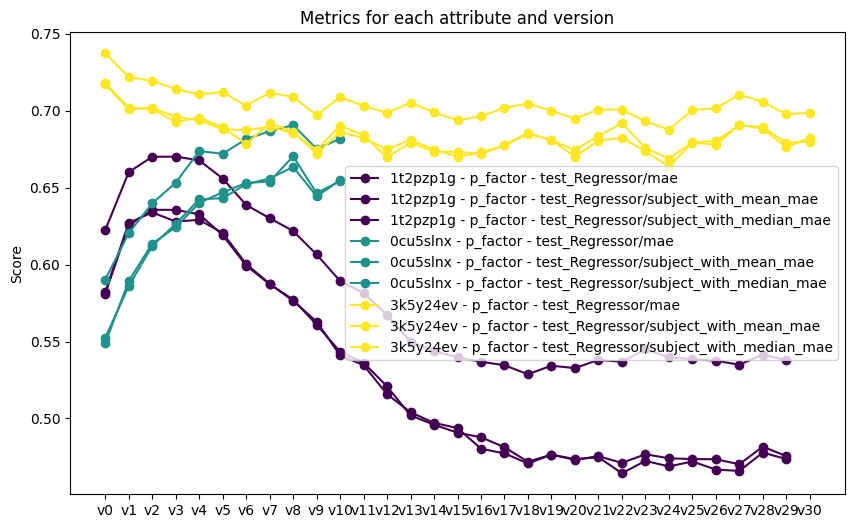

In [7]:
attributes = ['p_factor']
plot_metrics(version_scores, metrics, attributes, ['1t2pzp1g', '0cu5slnx', '3k5y24ev'])

/tmp/ipykernel_3701540/1723691987.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(models))


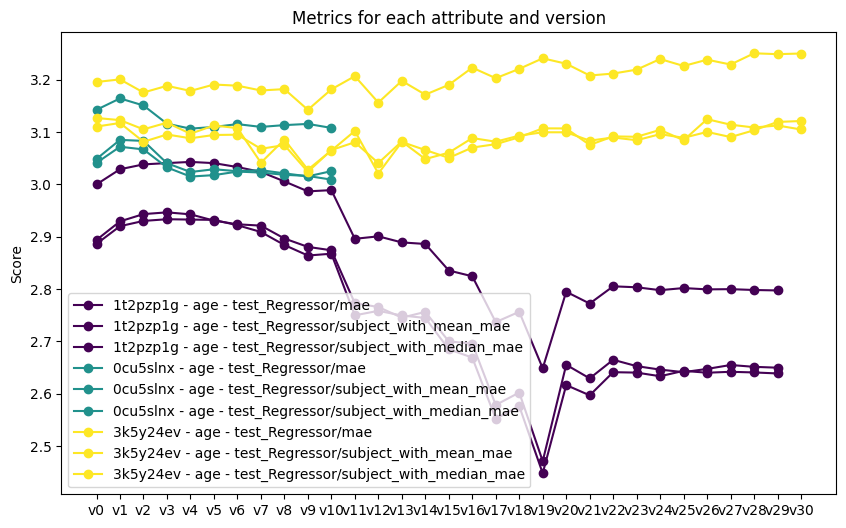

In [8]:
attributes = ['age']
plot_metrics(version_scores, metrics, attributes, ['1t2pzp1g', '0cu5slnx', '3k5y24ev'])

# Embeddings visualization

In [7]:
from libs.ssl_task import CPC
import numpy as np
# load config from runs/config_CPC.yaml
import yaml
import lightning as L
with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)

ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['target_label'] = 'age'
# config['data']['mapping'] = {'M': -1.0, 'F': 1.0}
mode = 'validate'
print('Loading data module...')
litDataModule = SSLHBNDataModule(**config['data'])
litDataModule.setup(stage=mode)

model = "0cu5slnx" #"3k5y24ev"
artifact_dir = f'artifacts/model-{model}'
num_version = 11 if model == "0cu5slnx" else 31

if model == "0cu5slnx":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRContextualizer'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None}
elif model == "3k5y24ev":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRLSTM'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512}

version = 4
artifact_path = f'{artifact_dir}:v{version}/model.ckpt'
print(f'Loading model from {artifact_path}...')
cpc_model = CPC.CPCLit.load_from_checkpoint(artifact_path, **config['model']['init_args'])
# scores = trainer.test(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)

Loading data module...
Loading model from artifacts/model-0cu5slnx:v4/model.ckpt...


In [8]:
val_dataloader = litDataModule.val_dataloader()
labels = []
embeddings = []
for batch in val_dataloader:
    x = batch[0].to('cuda')
    z = cpc_model.encoder(x)
    batch_size, feat, samples = z.shape
    Y, subjects = batch[1], batch[3]
    
    c = cpc_model.contextualizer(z)
    
    c_last = c[:, :, -1]
    embeddings.append(c_last.cpu().detach().numpy())
    labels.append(Y.cpu().detach().numpy())


In [9]:
labels = np.concatenate(labels)
embeddings = np.concatenate(embeddings)
print(labels.shape, embeddings.shape)

(2821,) (2821, 512)


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


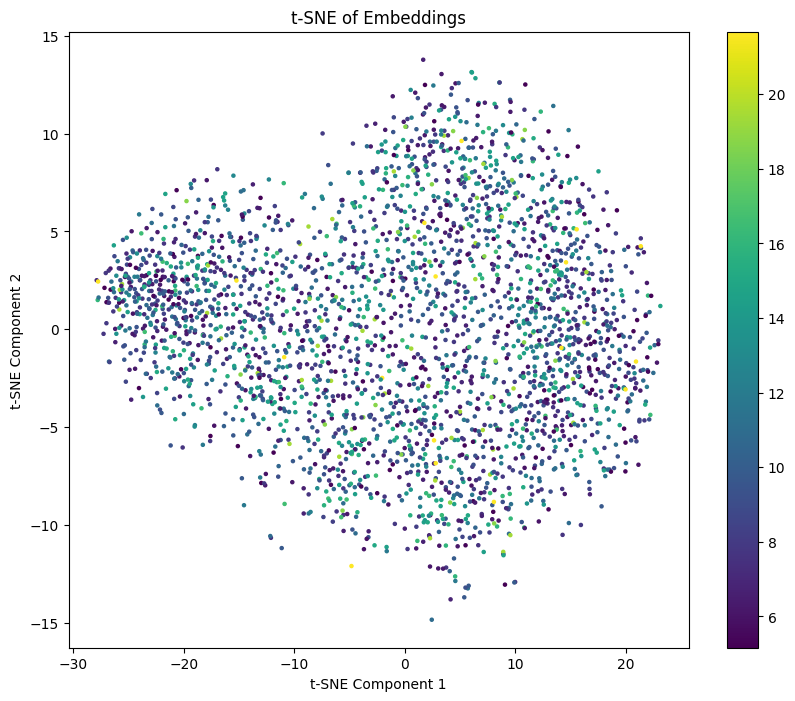

In [10]:
# plot the embeddings using t-SNE and color by the labels using their histogram bins
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def plot_tsne(embeddings, labels, n_components=2):
    # Standardize the data
    # scaler = StandardScaler()
    # embeddings = scaler.fit_transform(embeddings)

    # # Reduce the dimensionality of the data using PCA
    # pca = PCA(n_components=n_components)
    # embeddings_pca = pca.fit_transform(embeddings)

    # Create a t-SNE object and fit it to the PCA-reduced data
    tsne = TSNE(n_components=n_components, perplexity=60, n_iter=10000)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Create a scatter plot of the t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title('t-SNE of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
plot_tsne(embeddings, labels, n_components=2)

In [6]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [82]:
S_points = embeddings
S_color = labels

In [83]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


# plot_3d(S_points, S_color, "Original S-curve samples")

In [84]:
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "dense",
    "random_state": 0,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **params)
S_standard = lle_standard.fit_transform(embeddings)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **params)
S_ltsa = lle_ltsa.fit_transform(embeddings)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
S_hessian = lle_hessian.fit_transform(embeddings)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **params)
S_mod = lle_mod.fit_transform(embeddings)

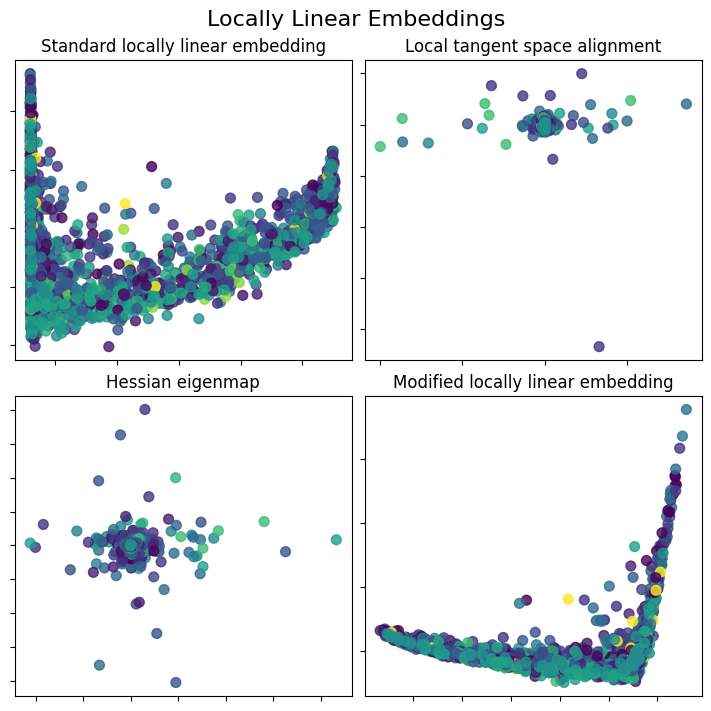

In [85]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True
)
fig.suptitle("Locally Linear Embeddings", size=16)

lle_methods = [
    ("Standard locally linear embedding", S_standard),
    ("Local tangent space alignment", S_ltsa),
    ("Hessian eigenmap", S_hessian),
    ("Modified locally linear embedding", S_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    add_2d_scatter(ax, points, S_color, name)

plt.show()

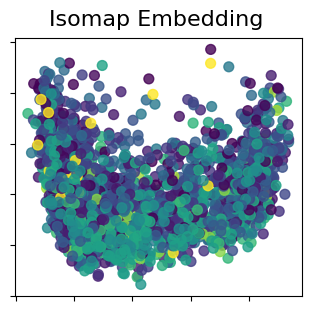

In [86]:
isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

plot_2d(S_isomap, S_color, "Isomap Embedding")

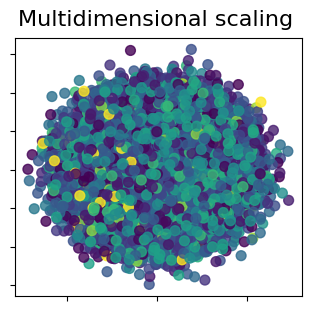

In [87]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(S_points)

plot_2d(S_scaling, S_color, "Multidimensional scaling")

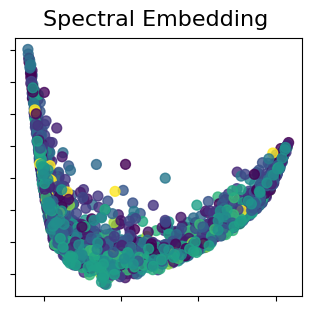

In [88]:
spectral = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
S_spectral = spectral.fit_transform(S_points)

plot_2d(S_spectral, S_color, "Spectral Embedding")

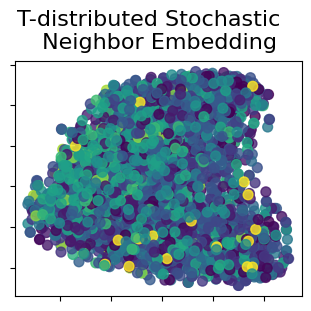

In [89]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    max_iter=2000,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(S_points)

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

## Evaluate using linear least square

### P_factor

In [ ]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
from libs.ssl_task import CPC
from libs.evaluation import train_projection_layer_for_eval
from libs.ssl_data import SSLHBNDataModule
import yaml

with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)
ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['target_label'] = 'p_factor'
litDataModule = SSLHBNDataModule(**config['data'], train_percent=0.6)
litDataModule.setup(stage='fit')



In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
print('No training. At initialization')
model = CPC.CPCLit(**config['model']['init_args'])
score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)


In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
for version in range(10):
    print(f'loading model version {version}')
    model = CPC.CPCLit.load_from_checkpoint(f'/home/dung/eeg-ssl/notebooks/artifacts/model-1t2pzp1g:v{version}/model.ckpt')
    score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)

### Age


In [ ]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
from libs.ssl_task import CPC
from libs.evaluation import train_projection_layer_for_eval
from libs.ssl_data import SSLHBNDataModule
import yaml

with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)
ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['target_label'] = 'age'
litDataModule = SSLHBNDataModule(**config['data'], train_percent=0.6)
litDataModule.setup(stage='fit')



In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
print('No training. At initialization')
model = CPC.CPCLit(**config['model']['init_args'])
score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)


In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
for version in range(10):
    print(f'loading model version {version}')
    model = CPC.CPCLit.load_from_checkpoint(f'/home/dung/eeg-ssl/notebooks/artifacts/model-1t2pzp1g:v{version}/model.ckpt')
    score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)


### Gender regression

In [ ]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
from libs.ssl_task import CPC
from libs.evaluation import train_projection_layer_for_eval
from libs.ssl_data import SSLHBNDataModule
import yaml

with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)
ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['target_label'] = 'sex'
config['data']['mapping'] = {'M': -1.0, 'F': 1.0}
litDataModule = SSLHBNDataModule(**config['data'], train_percent=0.6)
litDataModule.setup(stage='fit')



In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
print('No training. At initialization')
model = CPC.CPCLit(**config['model']['init_args'])
score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)


In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
scores = []
for version in range(10):
    print(f'loading model version {version}')
    model = CPC.CPCLit.load_from_checkpoint(f'/home/dung/eeg-ssl/notebooks/artifacts/model-1t2pzp1g:v{version}/model.ckpt')
    score = train_projection_layer_for_eval(model, train_dataloader=litDataModule.train_dataloader(), val_dataloader=litDataModule.val_dataloader(), regressor=regressor)